In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob


In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d 'andrewmvd/car-plate-detection'

 95% 193M/203M [00:04<00:00, 39.2MB/s]
100% 203M/203M [00:04<00:00, 44.8MB/s]


In [7]:
!unzip /content/car-plate-detection.zip

Archive:  /content/car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/

In [8]:
IMAGE_SIZE = 200


In [9]:
img_dir = "images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() 
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [10]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [11]:
path = 'annotations'
text_files = ['annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [12]:
resizeannotation("annotations/Cars147.xml")


[168, 126, 90, 93]

In [13]:
y[0]

[167, 129, 90, 93]

In [14]:
np.array(X).shape


(433, 200, 200, 3)

In [15]:
np.array(y).shape


(433, 4)

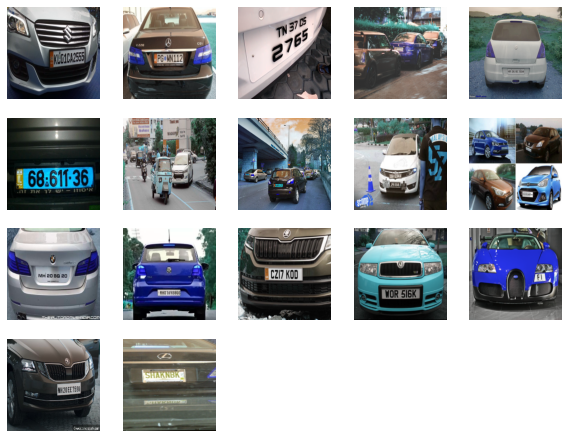

In [16]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

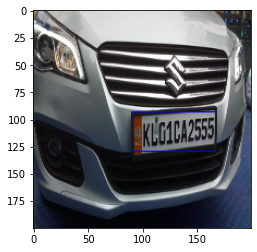

In [17]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

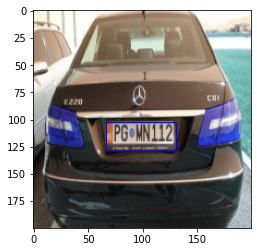

In [18]:
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [19]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [20]:
X = X / 255
y = y / 255

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [22]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [23]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [25]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
13/13 [==============================] - 60s 743ms/step - loss: 0.0552 - accuracy: 0.2941 - val_loss: 0.0159 - val_accuracy: 0.6364
Epoch 2/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0164 - accuracy: 0.5766 - val_loss: 0.0084 - val_accuracy: 0.7500
Epoch 3/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0085 - accuracy: 0.6584 - val_loss: 0.0090 - val_accuracy: 0.4773
Epoch 4/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0046 - accuracy: 0.6608 - val_loss: 0.0049 - val_accuracy: 0.8636
Epoch 5/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0027 - accuracy: 0.7936 - val_loss: 0.0046 - val_accuracy: 0.7273
Epoch 6/50
13/13 [==============================] - 3s 230ms/step - loss: 0.0016 - accuracy: 0.8266 - val_loss: 0.0043 - val_accuracy: 0.8409
Epoch 7/50
13/13 [==============================] - 3s 229ms/step - loss: 9.5538e-04 - accuracy: 0.9029 - val_loss: 0.0042 - val_accuracy: 0.7955
E

In [26]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.91%


In [27]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

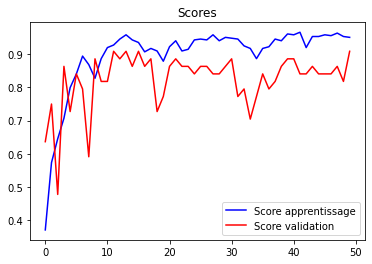

In [28]:
plot_scores(train)


In [38]:
 y_cnn = model.predict(X_test)
y_cnn

array([[2.33981356e-01, 6.89967215e-01, 4.37300449e-04, 1.82524063e-02],
       [7.72912800e-01, 5.82629144e-01, 4.14816022e-04, 3.72798786e-05],
       [3.09153199e-01, 8.69416952e-01, 3.46465749e-05, 1.15265604e-03],
       [2.18896240e-01, 8.33338082e-01, 2.78390915e-04, 1.63685542e-03],
       [3.19210023e-01, 7.29708612e-01, 1.11549329e-02, 1.13106873e-02],
       [9.21381652e-01, 9.42395151e-01, 6.27763450e-01, 6.26834333e-01],
       [2.83107758e-01, 8.88091505e-01, 2.26629472e-05, 1.02957912e-01],
       [2.16854736e-02, 9.80267286e-01, 2.71452819e-07, 6.01226203e-02],
       [5.90521216e-01, 7.59132862e-01, 2.69279862e-03, 4.54126149e-01],
       [4.32040542e-01, 8.61146033e-01, 2.28080130e-03, 4.98818099e-01],
       [9.48270559e-01, 6.95321918e-01, 4.96634275e-01, 3.32024872e-01],
       [9.86524105e-01, 9.69634414e-01, 1.00083962e-01, 6.94838986e-02],
       [6.47192717e-01, 8.84628832e-01, 1.70155596e-02, 3.84050518e-01],
       [7.12327242e-01, 9.47359204e-01, 1.24562616e

In [30]:
y_cnn.shape


(44, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

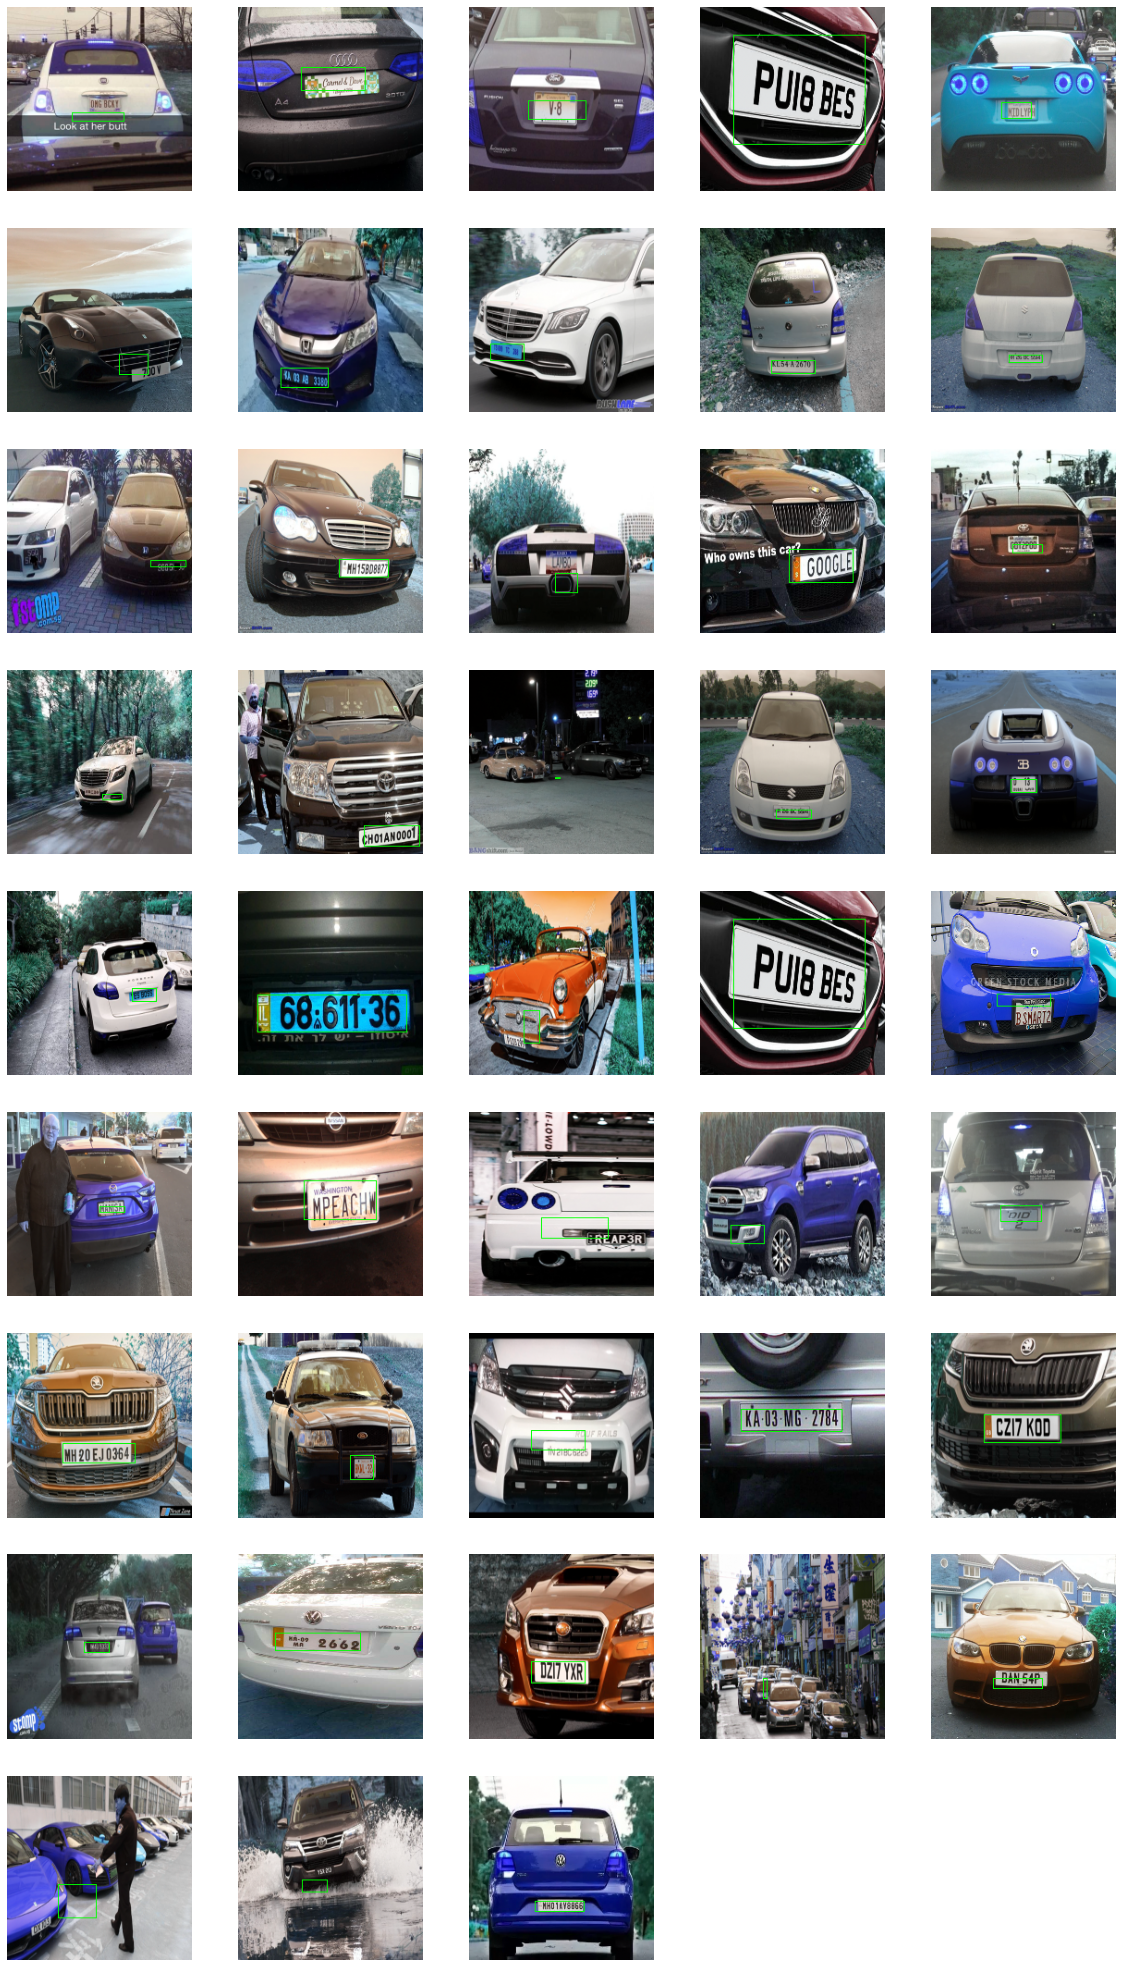

In [31]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

In [34]:
import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)


model.save(export_path_keras)

./1624968725.h5


In [36]:
!zip -r model.zip {export_path_keras}

  adding: 1624968725.h5 (deflated 10%)


In [37]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from tensorflow import keras
model = keras.models.load_model('model.h5')


In [130]:
import random, os,cv2
IMAGE_SIZE=200
X=[]
path = r"dataset/"
i=5
while(i>0):
    random_filename = random.choice([
        x for x in os.listdir(path)
        if os.path.isfile(os.path.join(path, x))
    ])
    print(random_filename)
    img = cv2.imread('dataset/'+random_filename,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    i=i-1
    

Cars408.png
Cars157.png
Cars95.png
Cars105.png
Cars229.png


In [131]:
np.array(X).shape
X=np.array(X)


In [132]:
X = X / 255
y_cnn = model.predict(X)
y_cnn

array([[0.3830426 , 0.6689997 , 0.31618607, 0.64286673],
       [0.7242801 , 0.5166226 , 0.64324474, 0.44079167],
       [0.5197556 , 0.51606035, 0.34519452, 0.35610247],
       [0.4079403 , 0.5478851 , 0.30480078, 0.5333091 ],
       [0.5658403 , 0.61119163, 0.4989076 , 0.5800016 ]], dtype=float32)

In [133]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pytesseract
import PIL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


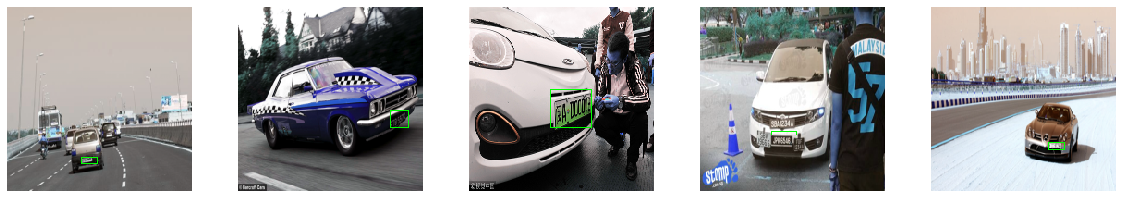

In [143]:
plt.figure(figsize=(20,40))
for i in range(0,5) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)